Proximal Policy Optimization (PPO) Implementation
Overview
PPO is an on-policy reinforcement learning algorithm that strikes a balance between:
- Sample efficiency (better than vanilla policy gradient)
- Implementation simplicity (easier than TRPO)
- Performance stability (clipped objective prevents destructive updates)
Key Components:
1 Actor-Critic Architecture: Separate networks for policy (actor) and value function (critic)
2 Clipped Surrogate Objective: Prevents large policy updates
3 Generalized Advantage Estimation (GAE): Reduces variance in advantage estimates
4 Multiple Epochs: Reuses collected data for efficiency
 Mathematical Foundation:
- PPO Objective: L^CLIP(θ) = E[min(r_t(θ)Â_t, clip(r_t(θ), 1-ε, 1+ε)Â_t)]
  - r_t(θ) = π_θ(a|s) / π_θ_old(a|s) is the probability ratio
  - Â_t is the advantage estimate
  - ε (epsilon) is the clipping parameter

In [ ]:
# Importing Required Libraries
import sys
import numpy as np # numpy for vector calculations
import matplotlib.pyplot as plt # For visualization and Results
import torch # import Pytorch
import torch.nn as nn # Neural Network
import torch.optim as optim #Neural Network Optimizer
import torch.nn.functional as F
from torch.distributions import Categorical, Normal # Categorical - Discrete Action Space , Normal - Continious Action Space
import gymnasium as gym  # enviroments or MDP
from collections import deque # to compute moving averages
import pickle #storing Policies
from typing import List, Tuple, Dict #readability and type safety
import time #benchmarking\logging
import copy

In [ ]:
# Seeding for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Below is the PPOMemory class which uses list to store states , actions  , probability of the action , value function  , rewards and termination status store_memory() stores the data at each timestep into these list while clear_memory() cleares these lists to make room for new episode run

In [ ]:
class PPOMemory:
    
    def __init__(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

Given Below are the actor and Critic network the actor network returns a categorical distribution for discrete action space and a normal distribution for continuous action space the hiddlen layers are defined as per enviroment as well as the activation is taken as ReLU The CriticNetwork similar to the valueNetwork used in TRPO and VPG also takes a state and outputs the value function estimate which is later used for calculating the advantage function the architecture is taken the same for the actor and critic network to which is the neural network with 2 hidden layers input for actor is the current state and output is a probability distribution over all possible action from whihc one action is sampled over time 

In [ ]:
class ActorNetwork(nn.Module):
  
    def __init__(self, state_dim, action_dim, hidden_sizes, is_continuous=False):
        super(ActorNetwork, self).__init__()
        
        self.is_continuous = is_continuous
        
        layers = []
        input_dim = state_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        self.network = nn.Sequential(*layers)
        
        if not is_continuous:
            self.action_head = nn.Linear(input_dim, action_dim)
        else:
            self.mean_head = nn.Linear(input_dim, action_dim)
            self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        features = self.network(state)
        
        if not self.is_continuous:
            logits = self.action_head(features)
            dist = Categorical(logits=logits)
        else:
            mean = self.mean_head(features)
            std = torch.exp(self.log_std)
            dist = Normal(mean, std)
        
        return dist


class CriticNetwork(nn.Module):
   
    def __init__(self, state_dim, hidden_sizes):
        super(CriticNetwork, self).__init__()
        
        layers = []
        input_dim = state_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            input_dim = hidden_size
        
        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, state):
        return self.network(state).squeeze(-1)

Given Below is the PPOAgent class the choose_action() functions selects an action from for current state using the policy that we got so far and returns the action and the probability and value function remember() stores the transisition in the list mentioned in the  compute_gae() is used for caluclating the generalized advantage function using TD residual and recusrisuve relations to speed up efficiency in the learn() function the states are split into random batches then prediction is made using the curent policy using this ratio of policy is calculated and we get surrogate loss to update the actorNetwork whereas the mean squared loss of the value functions gives us the update for the criticNetwork the updates are done in mutiple epoch where in each epoch the dataset divided into batches

In [ ]:
class PPOAgent:
    
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        is_continuous: bool,
        lr: float = 3e-4,
        gamma: float = 0.99,
        gae_lambda: float = 0.95,
        clip_epsilon: float = 0.2,
        hidden_sizes: List[int] = None,
        n_epochs: int = 10,
        batch_size: int = 64,
        entropy_coef: float = 0.01,
        value_coef: float = 0.5,
        max_grad_norm: float = 0.5
    ):
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.is_continuous = is_continuous
        self.batch_size = batch_size
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        
        if hidden_sizes is None:
            hidden_sizes = [64, 64]
        
        self.actor = ActorNetwork(state_dim, action_dim, hidden_sizes, is_continuous).to(device)
        self.critic = CriticNetwork(state_dim, hidden_sizes).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        
        self.memory = PPOMemory()
    
    def choose_action(self, observation):
        
        state = torch.FloatTensor(observation).unsqueeze(0).to(device)
        
        with torch.no_grad():
            dist = self.actor(state)
            value = self.critic(state)
            action = dist.sample()
            
            if self.is_continuous:
                log_prob = dist.log_prob(action).sum(dim=-1)
                action = action.cpu().numpy()[0]
            else:
                log_prob = dist.log_prob(action)
                action = action.item()
            
            log_prob = log_prob.item()
            value = value.item()
        
        return action, log_prob, value
    
    def remember(self, state, action, log_prob, value, reward, done):
        
        self.memory.store_memory(state, action, log_prob, value, reward, done)
    
    def compute_gae(self, rewards, values, dones, last_value=0):
        
        advantages = []
        gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = last_value
            else:
                next_value = values[t + 1]
            
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        
        return advantages
    
    def learn(self):
        
        if len(self.memory.states) == 0:
            return
        
        states = np.array(self.memory.states)
        actions = np.array(self.memory.actions)
        old_log_probs = np.array(self.memory.probs)
        values = np.array(self.memory.vals)
        rewards = np.array(self.memory.rewards)
        dones = np.array(self.memory.dones)
        
        if not dones[-1]:
            with torch.no_grad():
                last_state = torch.FloatTensor(states[-1]).unsqueeze(0).to(device)
                last_value = self.critic(last_state).item()
        else:
            last_value = 0
        
        advantages = self.compute_gae(rewards, values, dones, last_value)
        advantages = np.array(advantages)
        
        returns = advantages + values
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        states_tensor = torch.FloatTensor(states).to(device)
        actions_tensor = torch.FloatTensor(actions).to(device) if self.is_continuous else torch.LongTensor(actions).to(device)
        old_log_probs_tensor = torch.FloatTensor(old_log_probs).to(device)
        advantages_tensor = torch.FloatTensor(advantages).to(device)
        returns_tensor = torch.FloatTensor(returns).to(device)
        
        dataset_size = len(states)
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(dataset_size)
            
            for start_idx in range(0, dataset_size, self.batch_size):
                end_idx = min(start_idx + self.batch_size, dataset_size)
                batch_indices = indices[start_idx:end_idx]
                
                batch_states = states_tensor[batch_indices]
                batch_actions = actions_tensor[batch_indices]
                batch_old_log_probs = old_log_probs_tensor[batch_indices]
                batch_advantages = advantages_tensor[batch_indices]
                batch_returns = returns_tensor[batch_indices]
                
                dist = self.actor(batch_states)
                
                if self.is_continuous:
                    new_log_probs = dist.log_prob(batch_actions).sum(dim=-1)
                else:
                    new_log_probs = dist.log_prob(batch_actions)
                
                entropy = dist.entropy().mean()
                
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                
                actor_loss = -torch.min(surr1, surr2).mean() - self.entropy_coef * entropy
                
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.actor_optimizer.step()
                
                values_pred = self.critic(batch_states)
                critic_loss = nn.MSELoss()(values_pred, batch_returns)
                
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.critic_optimizer.step()
        
        self.memory.clear_memory()

the train_ppo() function is used by the ppo agent to interact wit enviroment and using this the rewards per episode as well as the moving average over 100 such episodes is stored and at end of each 50 episodes data is logged for parameter tuning debugging 

In [ ]:
def train_ppo(
    env_name: str,
    num_episodes: int = 1000,
    lr: float = 3e-4,
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    clip_epsilon: float = 0.2,
    hidden_sizes: List[int] = None,
    print_freq: int = 50,
    max_steps: int = 1000,
    n_epochs: int = 10,
    batch_size: int = 64,
    update_timesteps: int = 2048,
    entropy_coef: float = 0.01
) -> Tuple[PPOAgent, List[float], List[float]]:
  
    
    try:
        env = gym.make(env_name)
    except Exception as e:
        print(f"Error creating environment {env_name}: {e}")
        raise
    
    state_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    
    if is_continuous:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n
    
    if hidden_sizes is None:
        hidden_sizes = [64, 64]
    
    print(f"\n{'='*60}")
    print(f"Training PPO on {env_name}")
    print(f"{'='*60}")
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    print(f"Action space type: {'Continuous' if is_continuous else 'Discrete'}")
    print(f"Network architecture: {hidden_sizes}")
    print(f"Learning rate: {lr}")
    print(f"PPO epochs per update: {n_epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Update every: {update_timesteps} timesteps")
    print(f"Entropy coefficient: {entropy_coef}")
    print(f"{'='*60}\n")
    
    agent = PPOAgent(state_dim, action_dim, is_continuous, lr, gamma,
                     gae_lambda, clip_epsilon, hidden_sizes, n_epochs, batch_size,
                     entropy_coef=entropy_coef)
    
    episode_rewards = []
    moving_avg_rewards = []
    start_time = time.time()
    
    timesteps = 0
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        
        for step in range(max_steps):
            action, log_prob, value = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.remember(state, action, log_prob, value, reward, done)
            
            timesteps += 1
            
            if timesteps % update_timesteps == 0:
                agent.learn()
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        window = min(100, episode + 1)
        moving_avg = np.mean(episode_rewards[-window:])
        moving_avg_rewards.append(moving_avg)
        
        if (episode + 1) % print_freq == 0:
            elapsed_time = time.time() - start_time
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Reward: {episode_reward:.2f} | "
                  f"Avg (100): {moving_avg:.2f} | "
                  f"Time: {elapsed_time:.1f}s")
    
    env.close()
    
    print(f"\n{'='*60}")
    print(f"Training completed in {time.time() - start_time:.1f}s")
    print(f"Final average reward (last 100): {moving_avg_rewards[-1]:.2f}")
    print(f"{'='*60}\n")
    
    return agent, episode_rewards, moving_avg_rewards

evaluate_agent() takes the learned policy and run 100 of episodes and computes the rewards with its mean and std deviaiton the plot_single_enviroment() uses the reward data during training and plots it for a single enviroment so instead of running 5 env sequentially and plotting it later the plots and evaluation are generated after it runs on one enviroment and print_summary_table() prints the results for each enviroment and run_experiments() consists of the enviroments configuration as well as the main loop to call above functions and do the traiing and evaluation phase

Using device: cuda
PPO - MULTI-ENVIRONMENT COMPARISON

################################################################################
# EXPERIMENT: HalfCheetah-v5
################################################################################


Training PPO on HalfCheetah-v5
State dimension: 17
Action dimension: 6
Action space type: Continuous
Network architecture: [256, 256]
Learning rate: 0.0005
PPO epochs per update: 10
Batch size: 64
Update every: 2048 timesteps
Entropy coefficient: 0.0

Episode 50/3000 | Reward: -606.55 | Avg (100): -662.34 | Time: 43.4s
Episode 100/3000 | Reward: -354.92 | Avg (100): -556.39 | Time: 91.4s
Episode 150/3000 | Reward: -3.88 | Avg (100): -341.50 | Time: 141.9s
Episode 200/3000 | Reward: -120.51 | Avg (100): -137.49 | Time: 193.8s
Episode 250/3000 | Reward: 346.35 | Avg (100): 70.11 | Time: 245.7s
Episode 300/3000 | Reward: 532.43 | Avg (100): 272.65 | Time: 298.5s
Episode 350/3000 | Reward: 919.62 | Avg (100): 542.88 | Time: 340.2s
Episode 400/300

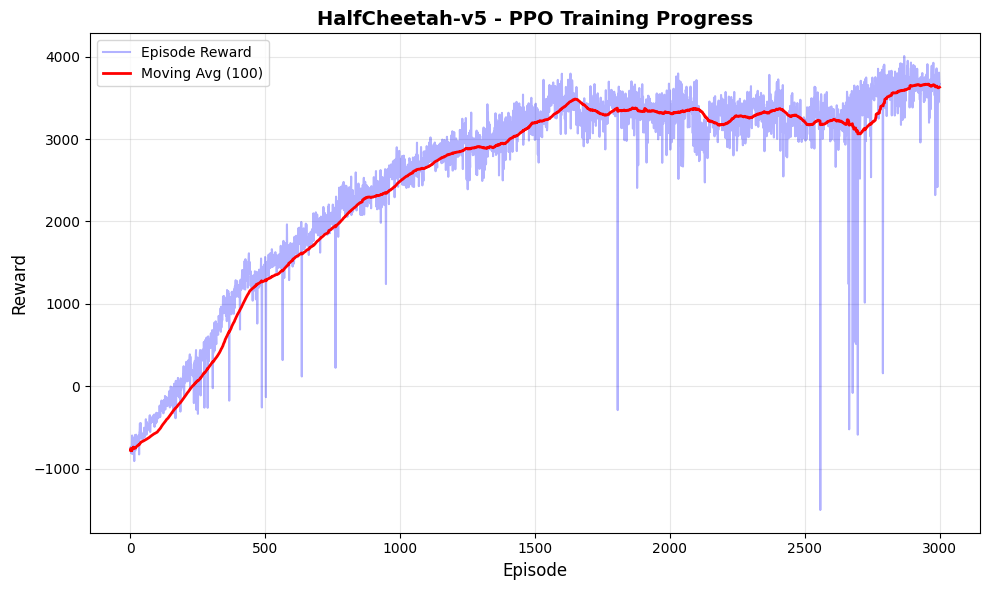


Evaluating trained agent on HalfCheetah-v5...
Evaluation Results: 3397.26 ± 587.14


################################################################################
# EXPERIMENT: InvertedPendulum-v5
################################################################################


Training PPO on InvertedPendulum-v5
State dimension: 4
Action dimension: 1
Action space type: Continuous
Network architecture: [64, 64]
Learning rate: 0.001
PPO epochs per update: 3
Batch size: 32
Update every: 1024 timesteps
Entropy coefficient: 0.0

Episode 50/2000 | Reward: 7.00 | Avg (100): 7.46 | Time: 0.5s
Episode 100/2000 | Reward: 10.00 | Avg (100): 7.13 | Time: 0.9s
Episode 150/2000 | Reward: 5.00 | Avg (100): 7.88 | Time: 1.8s
Episode 200/2000 | Reward: 19.00 | Avg (100): 9.51 | Time: 2.4s
Episode 250/2000 | Reward: 20.00 | Avg (100): 14.73 | Time: 3.7s


KeyboardInterrupt: 

In [13]:

def plot_single_environment(env_name: str, episode_rewards: List[float], 
                           moving_avg: List[float], save_path: str = None):
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    episodes = range(1, len(episode_rewards) + 1)
    
    ax.plot(episodes, episode_rewards, alpha=0.3, label='Episode Reward', color='blue')
    ax.plot(episodes, moving_avg, linewidth=2, label='Moving Avg (100)', color='red')
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Reward', fontsize=12)
    ax.set_title(f'{env_name} - PPO Training Progress', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


def evaluate_agent(
    agent: PPOAgent,
    env_name: str,
    num_episodes: int = 100,
    max_steps: int = 1000
) -> Tuple[float, float]:
    
    
    env = gym.make(env_name)
    eval_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            action, _, _ = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        eval_rewards.append(episode_reward)
    
    env.close()
    
    mean_reward = np.mean(eval_rewards)
    std_reward = np.std(eval_rewards)
    
    return mean_reward, std_reward


def print_summary_table(results: Dict):
 
    if len(results) == 0:
        print("\nNo results to summarize.")
        return
    
    print("\n" + "="*80)
    print("SUMMARY OF PPO RESULTS")
    print("="*80)
    print(f"{'Environment':<30} {'Final Avg':<15} {'Eval Mean ± Std':<25}")
    print("-"*80)
    
    for env_name, data in results.items():
        final_avg = data['moving_avg_rewards'][-1]
        eval_mean = data['eval_mean']
        eval_std = data['eval_std']
        
        print(f"{env_name:<30} {final_avg:>13.2f} {eval_mean:>12.2f} ± {eval_std:<10.2f}")
    
    print("="*80 + "\n")


def run_experiments():
    """Run PPO experiments on multiple environments"""
    
    environments = {
            'HalfCheetah-v5': {
            'num_episodes': 3000,
            'lr': 5e-4,
            'max_steps': 1000,
            'hidden_sizes': [256, 256],
            'n_epochs': 10,
            'batch_size': 64,
            'clip_epsilon': 0.15,
            'update_timesteps': 2048,
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'entropy_coef': 0.0
        },
            'InvertedPendulum-v5': {
        'num_episodes': 2000,
        'lr': 1e-3,
        'max_steps': 1000,
        'hidden_sizes': [64, 64],
        'n_epochs': 3,
        'batch_size': 32,
        'clip_epsilon': 0.3,
        'update_timesteps': 1024,
        'gamma': 0.99,
        'gae_lambda': 0.97,
        'entropy_coef': 0.0
    },
        'CartPole-v1': {
            'num_episodes': 2000,
            'lr': 3e-4,
            'max_steps': 500,
            'hidden_sizes': [64, 64],
            'n_epochs': 10,
            'batch_size': 64,
            'clip_epsilon': 0.2,
            'update_timesteps': 2048,
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'entropy_coef': 0.01
        },
        'Acrobot-v1': {
            'num_episodes': 2000,
            'lr': 3e-4,
            'max_steps': 500,
            'hidden_sizes': [64, 64],
            'n_epochs': 10,
            'batch_size': 64,
            'clip_epsilon': 0.2,
            'update_timesteps': 2048,
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'entropy_coef': 0.01
        },
      
        'LunarLanderContinuous-v3': {
            'num_episodes': 2000,
            'lr': 3e-4,
            'max_steps': 1000,
            'hidden_sizes': [256, 256],
            'n_epochs': 10,
            'batch_size': 64,
            'clip_epsilon': 0.2,
            'update_timesteps': 2048,
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'entropy_coef': 0.0
        }
    
    }
    
    results = {}
    
    for env_name, config in environments.items():
        print(f"\n{'#'*80}")
        print(f"# EXPERIMENT: {env_name}")
        print(f"{'#'*80}\n")
        
        try:
            agent, episode_rewards, moving_avg_rewards = train_ppo(
                env_name=env_name,
                num_episodes=config['num_episodes'],
                lr=config['lr'],
                gamma=config['gamma'],
                gae_lambda=config['gae_lambda'],
                clip_epsilon=config['clip_epsilon'],
                hidden_sizes=config['hidden_sizes'],
                print_freq=50,
                max_steps=config['max_steps'],
                n_epochs=config['n_epochs'],
                batch_size=config['batch_size'],
                update_timesteps=config['update_timesteps'],
                entropy_coef=config['entropy_coef']
            )
            
            # Plot immediately after training
            plot_single_environment(env_name, episode_rewards, moving_avg_rewards, 
                                   save_path=f'{env_name}_ppo_training.png')
            
            print(f"\nEvaluating trained agent on {env_name}...")
            eval_mean, eval_std = evaluate_agent(agent, env_name, num_episodes=20)
            print(f"Evaluation Results: {eval_mean:.2f} ± {eval_std:.2f}\n")
            
            results[env_name] = {
                'agent': agent,
                'episode_rewards': episode_rewards,
                'moving_avg_rewards': moving_avg_rewards,
                'eval_mean': eval_mean,
                'eval_std': eval_std,
                'config': config
            }
            
            # Save models
            torch.save(agent.actor.state_dict(), f'{env_name}_ppo_actor.pth')
            torch.save(agent.critic.state_dict(), f'{env_name}_ppo_critic.pth')
            
        except Exception as e:
            print(f"Error training on {env_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    if len(results) > 0:
        print_summary_table(results)
    else:
        print("\nNo successful experiments to summarize.")
    
    return results


if __name__ == "__main__":
    print("="*80)
    print("PPO - MULTI-ENVIRONMENT COMPARISON")
    print("="*80)
    
    results = run_experiments()
    
    print("\n" + "="*80)
    print("ALL PPO EXPERIMENTS COMPLETED!")
    print("="*80)